In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tarfile
import os
import requests
import random
from tqdm import tqdm
from collections import namedtuple
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
from IPython.utils.io import capture_output
#InteractiveShell.ast_node_interactivity = "all"

In [2]:
np.random.seed(400)
random.seed(400)

# Intro
Simple notebook showing the steps to implement a NN from scratch. This short series consists of two parts, implementing one-layer nn and then extending it to m-layers nn. For this notebook, we are going to implement a one linear layer neural network with no activation for simplicity.  The task is image classifciation on cifar10 dataset, and the hope is to get a performance better than random guessing which given the 10 classes, should be $> 1/10$. This would indicate that it at least learnt something.

# Purpose 
There are lots of tutorials online, that are better than this notebook I'm constructing, like Karpathy's famous [micrograd series](https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ), but I wanted to take a more **analytical approach** as per my previous labs in a DL course I took years ago, showing how to go from a computational graph to deriving the math for the gradients to implementing them in a backprop and train the network. The hope is to show that this is a very mechanical process, aside from deriving some of the tricky gradients, there's a very clear pattern on how to work with this. What I had in mind should algorithmitcally be very straightforward, however the math for some of the gradients aren't trivial, and sometimes requires drawing the matrices to understand what's really happening. That's the only part I didn't find a simpler way to deal with, which I disliked, although I do think there are easier ways to work with them, something something about proper matrix calculus techniques. Admittedly, Karpathy's video is easier to understand and shorter code, since it's an implementation of automatic differentiation, whereas this implementation is purely analytical and not automatic. Regardless, it can serve as an alternative approach, to give a different perspective as it doesn't require implementing an automatic differentiation engine.

# Prerequisites
Basics of chain rule and familiarity with matrix calculus and working with matrices in general.

# Preprocess data
Originally 10000 x 32 x 32 x 3, but need to transpose it to get the same shape as in the formulas for the gradients in the derivations. There are 5 files + 1 test file and each file has 10k images. The test file has 10k as well.

* We will extract the first 10k for training and next 10k for validation. Also need to be in $d \times n$ shape, where d is the features and n the number of samples. The test data will be from the test_batch file.
* Labels should be one-hot encoding and in shape $c \times n$, where c is the classes and n the number of samples.
* Need to normalize data, subtract all data by training mean and divide by training std to turn it into zero mean unit variance data. This seems to be a [common practise](https://stats.stackexchange.com/a/202290), since the nn will be trained on the training data and therefore use those statistics. To make those statistics compatible we therefore need to transform the validation and test data the same way.

### Check where current folder is
We should access the cifar-10-python-tar.gz file in the data folder and extract it in the same folder. Adjust the paths accordingly if they are not correct. If the current folder path is chapter6, then it's correct.

In [6]:
current_path = os.getcwd()
print("Current folder path:", current_path) 

Current folder path: e:\training\TWIML-DL-Study-Group\chapter6


In [4]:
DATA_PATH = os.path.join("data")
CIFAR_ROOT_PATH = os.path.join(DATA_PATH, "cifar-10-batches-py")
TEST_DATA_BATCH_PATH = os.path.join(CIFAR_ROOT_PATH, "test_batch")
CIFAR_TAR_PATH = os.path.join(DATA_PATH, "cifar-10-python.tar.gz")

In [5]:
# Download cifar10, might take some time depending on internet speed, can take anywhere from few secs to a few minutes. Took me around 2mins.
if not os.path.exists(CIFAR_TAR_PATH):
    try:
        with requests.get("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz", stream=True, timeout=300) as response:
            response.raise_for_status()  # Raise an error for bad status codes
            with open(CIFAR_TAR_PATH, "wb") as file:
                for chunk in response.iter_content(chunk_size=1024):
                    with capture_output():
                        file.write(chunk)
        print("Download completed successfully.")
    except requests.exceptions.Timeout:
        print("The request timed out.")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        
if not os.path.exists(CIFAR_ROOT_PATH):
    with tarfile.open(CIFAR_TAR_PATH) as tar:
        tar.extractall(path=DATA_PATH)

In [6]:
# utils for preprocessing data

Data = namedtuple('Data', 'x y')

def load_data(file_path):
    with open(file_path, 'rb') as file:
        dict = pickle.load(file, encoding='bytes')
    return dict[b'data'], dict[b'labels']

def load_cifar10(number_of_batches):
    assert 0 < number_of_batches < 6
    data = []
    labels = []
    test_data, test_labels = load_data(TEST_DATA_BATCH_PATH)
    for i in range(1, number_of_batches + 1):
        d, l = load_data(os.path.join(CIFAR_ROOT_PATH, f"data_batch_{i}"))
        data.append(d)
        labels.append(l)
    # in data rows are samples so stack them on the rows with vstack
    # in labels columns are samples so stack them on the columns with hstack
    return np.vstack(data), np.hstack(labels), np.array(test_data), np.array(test_labels)

def train_valid_split(data, labels, split_ratio):
    assert type(split_ratio) is list and len(split_ratio) == 2 
    x_train, x_valid, y_train, y_valid = train_test_split(data, labels, train_size=split_ratio[0], test_size=split_ratio[1], shuffle=False)
    return x_train, y_train, x_valid, y_valid
    
def transform_data(x_train, x_valid, x_test, y_train, y_valid, y_test):
    # normalize data
    mean = np.mean(x_train, axis=0)
    std = np.std(x_train, axis=0)
    x_train = (x_train - mean) / std
    x_valid = (x_valid - mean) / std
    x_test = (x_test - mean) / std
    assert np.allclose(np.mean(x_train, axis=0), np.zeros(x_train.shape[1]))
    assert np.allclose(np.std(x_train, axis=0), np.ones(x_train.shape[1]))
    
    # transform data to d x n to adhere to the gradient formulas
    x_train = x_train.T
    x_valid = x_valid.T
    x_test = x_test.T
    
    # transform labels to one-hot encoding
    y_train_one_hot = np.zeros((10, y_train.size))
    y_train_one_hot[y_train, np.arange(y_train.size)] = 1
    y_valid_one_hot = np.zeros((10, y_valid.size))
    y_valid_one_hot[y_valid, np.arange(y_valid.size)] = 1
    y_test_one_hot = np.zeros((10, y_test.size))
    y_test_one_hot[y_test, np.arange(y_test.size)] = 1
    
    return Data(x_train, y_train_one_hot), Data(x_valid, y_valid_one_hot), Data(x_test, y_test_one_hot)


In [7]:
# Only load the first 20k data, first 10k is for training and other 10k is valid, test batch is a separate data with 10k
# data is wrapped in a Data namedtuple with field x for the data and y for the labels
number_of_batches = 2
x_data, y_data, x_test, y_test =  load_cifar10(number_of_batches)
assert x_data.shape == (number_of_batches * 10000, 3072)
assert y_data.shape == (number_of_batches * 10000,)
assert x_test.shape == (10000, 3072)
assert y_test.shape == (10000,)

# note that the split may not be even due to rounding so the assertions may give false, therefore try to use ratios
# that give even splits or comment out the assertions
train_ratio = 0.5
valid_ratio = 0.5
x_train, y_train, x_valid, y_valid = train_valid_split(x_data, y_data, [train_ratio, valid_ratio])
""" assert x_train.shape == (number_of_batches * 10000 * train_ratio, 3072)
assert x_valid.shape == (number_of_batches * 10000 * valid_ratio, 3072)
assert y_train.shape == (10000,)
assert y_valid.shape == (10000,) """

train, valid, test = transform_data(x_train, x_valid, x_test, y_train, y_valid, y_test)
train.x.shape
""" assert train.x.shape == (3072, number_of_batches * 10000 * train_ratio)
assert valid.x.shape == (3072, number_of_batches * 10000 * valid_ratio)
assert test.x.shape == (3072, 10000)
assert train.y.shape == (10, number_of_batches * 10000 * train_ratio)
assert valid.y.shape == (10, number_of_batches * 10000 * valid_ratio)
assert test.y.shape == (10, 10000) """

' assert train.x.shape == (3072, number_of_batches * 10000 * train_ratio)\nassert valid.x.shape == (3072, number_of_batches * 10000 * valid_ratio)\nassert test.x.shape == (3072, 10000)\nassert train.y.shape == (10, number_of_batches * 10000 * train_ratio)\nassert valid.y.shape == (10, number_of_batches * 10000 * valid_ratio)\nassert test.y.shape == (10, 10000) '

# Deriving the gradients for the NN

The computational graph we have for this network is illustrated below. Note that we only have one layer.

![](./assets/one_layer_nn_comp_graph.png)

where $J$ is the cost function, which takes the output from the final layer to compute the loss. Our functions are thus

$$J = l + \lambda r$$

$$r = \|w\|^2$$

$$l = -\log(y^T p)$$

$$p = \text{softmax}(s)$$

$$s = z + b$$

$$z = Wx$$

**Dimensions.** Note that 
* $y$ is a one-hot encoding, consisting of zeros except for one element that is 1, of size $c \times 1$ for a single data point and $c \times n$ for a dataset of size n. c stands for number of classes, in cifar10 that's 10 classes.
* $w$ is $c \times d$, where d is the number of features of the data.
* $x$ is $d \times 1$ for single data point and $d \times n$ for a batch of size n.
* $s$ is $c \times 1$ and $c \times n$.
* $p$ is $c \times 1$ and $c \times n$ for a batch.
* $l$ and $J$ both are scalars because they are loss functions.
* $r$ is a scalar, because it's the frobenius norm (l2-norm) of the matrix $w$.

At the core the process consists of just being comfortable with the chain rule, because that sets up the structure of the gradients, and being comfortable with matrix calculus is beneficial to actually compute the gradients, otherwise use the [matrix cookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf) if some of them are too tricky. Also knowing the dimensions of the variables and the intermediate results is crucial, both in coding and deriving the gradients.

We want to find the optimal parameters for the one linear layer neural network. This nn has $w$ and $b$ as model parameters, so these are the gradients we are looking for

$$\frac{\partial J}{\partial w} ,\, \frac{\partial J}{\partial b}$$

Following the computational graph, the backprop starts from the end and propagates to the start. Applying the chain rule on J w.r.t w we therefore get when we go backwards from J to z:

$$\frac{\partial J}{\partial w} = \textcolor{red}{\frac{\partial J}{\partial l} \frac{\partial l}{\partial p} \frac{\partial p}{\partial s}} \frac{\partial s}{\partial z} \frac{\partial z}{\partial w} + \frac{\partial J}{\partial r} \frac{\partial r}{\partial w}$$

similarily we get for J w.r.t b:
$$\frac{\partial J}{\partial b} = \textcolor{red}{\frac{\partial J}{\partial l} \frac{\partial l}{\partial p} \frac{\partial p}{\partial s}} \frac{\partial s}{\partial b}$$

I've highlighted the red part that occurs in both gradients. In the code we can be more efficient and store this as a variable to avoid recomputing it each time.

We start with one single data point and later extend it to a batch of data. Moreover, we use the [numerator layout](https://en.wikipedia.org/wiki/Matrix_calculus#Numerator-layout_notation) when computing the gradients. For clarification here's a simple example that should illustrate the idea of the numerator layout

$$
\frac{\partial f}{\partial x} =
\begin{bmatrix}
\frac{\partial f_{1}}{\partial x_{1}} \dots{} \frac{\partial f_{1}}{\partial x_{n}} \\
\vdots \\
\frac{\partial f_{m}}{\partial x_{1}} \dots{} \frac{\partial f_{m}}{\partial x_{n}}
\end{bmatrix}
$$

For row 1 we fix f and vary x. For row 2 we fix the next element in f, which is $f_{2}$ and vary x the same way. We do this all the way down to the last row m, which is we fix $f_m$ and vary x because there are only m outputs from the vector-valued function $f: \mathbb{R}^n \to \mathbb{R}^m$. This produces a $m \times n$ jacobian matrix that is the derivative of the vector-valued function $f$ w.r.t the vector $x$.
This pattern naturally applies to gradients and scalar functions with scalar inputs as well. So really it's a general method that works for all kinds of situations, as long as the derivative exists.


## Computing $\frac{\partial J}{\partial b}$
The gradient of J w.r.t b is the shortest so we start with it. Recall that we had 

$$\frac{\partial J}{\partial b} = \textcolor{red}{\frac{\partial J}{\partial l} \frac{\partial l}{\partial p} \frac{\partial p}{\partial s}} \frac{\partial s}{\partial b}$$

#### $\frac{\partial J}{\partial l}$
Computing one gradient at a time we have $\frac{\partial J}{\partial l} = \frac{\partial scalar}{\partial scalar} = scalar$ and given the function is $J = l + \lambda r$ we get

$$\frac{\partial J}{\partial l} = 1$$

#### $\frac{\partial l}{\partial p}$

For the next one remember that $\frac{\partial l}{\partial p}$ is of the form $\frac{\partial \text{scalar}}{\partial \text{vector}} = \text{vector}$, so we should get a gradient from this keeping in mind that we are using the numerator layout. The function is $l = -\log{y^T p}$ so we get

$$\frac{\partial l}{\partial p} = - \left(\frac{\partial l}{\partial p_1}, \frac{\partial l}{\partial p_2}, \dots, \frac{\partial l}{\partial p_c} \right) = - \left( \frac{y_1}{y^T p}, \dots, \frac{y_n}{y^T p} \right) = - \frac{y^T}{y^T p}$$

####  $\frac{\partial p}{\partial s}$

This one is not trivial, but applying the [quotient rule](https://en.wikipedia.org/wiki/Quotient_rule) for derivative will get you the answer, and with a smart conversion one can express the answer in matrix form. The function is $p = \text{softmax}(s) = \dfrac{\exp{s}}{1_c \exp{s}}$ where $1_c$ is a vector of size $c \times 1$ and s is the same size, which is the same as summing all the entries $\sum_j^c \exp{s_j}$. We get

$$\frac{\partial p_i}{\partial s_i} = \frac{\exp{s_i} (1_c \exp{s}) - \exp{s_i}\exp{s_i}}{(1_c \exp{s})^2} = \frac{\exp{s_i}}{1_c \exp{s}} \cdot \frac{1_c \exp{s} - \exp{s_i}}{1_c \exp{s}} = p_i(1-p_i), \ \ \  i=j$$

$$\frac{\partial p_i}{\partial s_j} = \frac{-\exp{s_i} \exp{s_j}}{(1_c \exp{s})^2} = -\frac{\exp{s_i}}{1_c \exp{s}} \cdot \frac{\exp{_js}}{1_c \exp{s}} = -(p_i p_j), \ \ \  i \neq j$$

$$
\iff 
\frac{\partial p}{\partial s} = 
\begin{cases}
p_i - p_i^2 \, ,i=j \\
-p_i p_j \, ,i \neq j
\end{cases}

\implies 
\frac{\partial p}{\partial s} = \text{diag}(p) - pp^T
$$

To arrive at the matrix form observe that $p_i$ is duplicated as a multiplication over all entries in the matrix as a negative factor $-p_i$, which suggests that we should use outer product $pp^T$ to get that form. Furthermore, at the diagonals we have a positive $p_i$, which suggests that we should take the $diag(p)$ and subtract it with the outer product of $pp^T$.

### $\frac{\partial s}{\partial b}$
We have the situation $\frac{\partial \text{vector}}{\partial \text{vector}} = \text{matrix}$ and observing that the function is $s = z + b$, the numerator layout will give

$$
\frac{\partial s}{\partial b} =
\begin{bmatrix}
\frac{\partial s_{1}}{\partial b_{1}} \dots{} \frac{\partial s_{1}}{\partial b_{c}} \\
\vdots \\
\frac{\partial s_{c}}{\partial b_{1}} \dots{} \frac{\partial s_{c}}{\partial b_{c}}
\end{bmatrix} =
\begin{bmatrix}
1 & 0 & \cdots & 0 \\
0 & 1 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & 1
\end{bmatrix} =
I_c
$$

where we can see that it's only on the diagonal that we get a non-zero result, in fact 1. This makes it an identity matrix of size $c \times c$.

### Putting $\frac{\partial J}{\partial b}$ together
Putting it together we get 

$$
\begin{align}
    \frac{\partial J}{\partial b} 
    &= \frac{\partial J}{\partial l} \frac{\partial l}{\partial p} \frac{\partial p}{\partial s} \frac{\partial s}{\partial b} \\
    &= 1 \cdot (-\frac{y^T}{y^T p}) \cdot (\text{diag}(p) - pp^T) \cdot I_c \\
    &= (-\frac{y^T}{y^T p}) \cdot (\text{diag}(p) - pp^T) \\
    &= (-\frac{1}{p_i})(\text{diag}(p) - pp^T)_i^T \\
    &= (-\frac{1}{p_i})(\text{diag}(p)_i - p_ip^T) \\
    &= (-\frac{1}{p_i})(p_i [0 \dots 1_i \dots 0] - p)^T \\
    &= -(y - p)^T
\end{align}
$$

The biggest insight comes from looking at $\text{diag}(p) - pp^T$ (I recommend to draw this) 

$$
\text{diag}(\mathbf{p}) - \mathbf{p} \mathbf{p}^T =
\begin{bmatrix}
p_1 - p_1^2 & -p_1 p_2 & \cdots & -p_1 p_c \\
-p_2 p_1 & p_2 - p_2^2 & \cdots & -p_2 p_c \\
\vdots & \vdots & \ddots & \vdots \\
-p_c p_1 & -p_c p_2 & \cdots & p_c - p_c^2
\end{bmatrix}
$$

and noticing that the one-hot encoding $y^T$ will choose the ith row of this matrix. You can further simplify that row by realizing that you can factor out $p_i$ from $\text{diag}(p)_i - p_ip^T$ and cancel it with $-\frac{1}{p_i}$, which leaves $-(y - p)^T$.

#

## Computing $\frac{\partial J}{\partial w}$

Recall we had the chain of gradients 

$$\frac{\partial J}{\partial w} = \textcolor{red}{\frac{\partial J}{\partial l} \frac{\partial l}{\partial p} \frac{\partial p}{\partial s}} \frac{\partial s}{\partial z} \frac{\partial z}{\partial w} + \textcolor{orange}{\frac{\partial J}{\partial r} \frac{\partial r}{\partial w}}$$

### $\textcolor{orange}{\frac{\partial J}{\partial r} \frac{\partial r}{\partial w}}$

The functions are $J = l + \lambda r$ and $r = \|w\|^2$ and it's easy to see that we get 

$$\frac{\partial J}{\partial r} \frac{\partial r}{\partial w} = \lambda 2w$$

### $\textcolor{red}{\frac{\partial J}{\partial l} \frac{\partial l}{\partial p} \frac{\partial p}{\partial s} \frac{\partial s}{\partial z}}$

We earlier computed this to be $-(y-p)^T$, but for convenience sake, we will set it as $g^T = -(y-p)^T$. This has the size $1 \times c$.

### $\frac{\partial s}{\partial z}$

The function is $s = z + b$, so we can see that we get the exact same situation as $\frac{\partial s}{\partial b} = I_c$.

### $\frac{\partial z}{\partial w}$

The function is $z = wx$.
This is probably the hardest one, making the computations more complicated because of the introduction of [kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) that is defined as

$$
\mathbf{A} \otimes \mathbf{B} =
\begin{bmatrix}
a_{11} \mathbf{B} & \cdots & a_{1n} \mathbf{B} \\
\vdots & \ddots & \vdots \\
a_{m1} \mathbf{B} & \cdots & a_{mn} \mathbf{B}
\end{bmatrix}
$$

where A and B are matrices.
We notice that we cannot solve 

$$\frac{\partial z}{\partial w}$$

in the traditional sense, since there isn't a standardized procedure for gradient of vector w.r.t a matrix. There are however different ways to solve it, one way in which the course did was to vectorize the matrix w by $\operatorname{vec}(w)$, write $z = wx = I_c wx$ and then use the following [relation](https://en.wikipedia.org/wiki/Vectorization_(mathematics)#Compatibility_with_Kronecker_products) $\operatorname{vec}(ABC) = (C^T \otimes A)\operatorname{vec}(B)$ to take the derivative of w.r.t $vec(B)$, which just removes it in the expression. Basically we get 

$$\frac{\partial \operatorname{vec}(z)}{\partial vec(w)} = \frac{\partial \operatorname{vec}(I_c wx)}{\partial vec(w)} = \frac{\partial (x^T \otimes I_c) \operatorname{vec}(w)}{\partial vec(w)} = (x^T \otimes I_c)$$

Notice that this has the size of $c \times cd$.

## Putting together $\frac{\partial J}{\partial w} = \textcolor{red}{\frac{\partial J}{\partial l} \frac{\partial l}{\partial p} \frac{\partial p}{\partial s}} \frac{\partial s}{\partial z} \frac{\partial z}{\partial w} + \frac{\partial J}{\partial r} \frac{\partial r}{\partial w}$

Recall that $\textcolor{red}{\frac{\partial J}{\partial l} \frac{\partial l}{\partial p} \frac{\partial p}{\partial s} \frac{\partial s}{\partial z}} = g^T$ is of size $1 \times c$ and $\frac{\partial z}{\partial w} = (x^T \otimes I_c)$ is size $c \times cd$. Multiplying them together we get 

$$
\begin{align}
\frac{\partial J}{\partial l} \frac{\partial l}{\partial p} \frac{\partial p}{\partial s} \frac{\partial s}{\partial z} \frac{\partial z}{\partial w} &= g^T(x^T \otimes I_c) \\
&= [g^Tx_1, g^Tx_2, \dots, g^Tx_d] \\
& \implies 
\begin{bmatrix}
g^Tx_1 \\
g^Tx_2 \\
\vdots \\
g^Tx_d
\end{bmatrix} \\
&= xg^T
\end{align}
$$

where we have converted the $1 \times cd$ matrix $[g^Tx_1, g^Tx_2, \dots, g^Tx_d]$ to size $d \times c$. We will need to transpose this from $(xg^T)^T = gx^T$ to make it size $c \times d$ to be able to add with $\frac{\partial J}{\partial r} \frac{\partial r}{\partial w}$ that is of size $c \times d$. The idea of simplifying the multiplication on the first line is that the identity matrix in the kronecker product will simplify alot, because of the many zero entries in the matrix. Finally we get the gradient

$$\frac{\partial J}{\partial w} = gx^T + 2\lambda w$$

## Extending to batches of data

Remember that the gradients computed

$$\frac{\partial J}{\partial w} = gx^T + 2\lambda w$$

$$\frac{\partial J}{\partial b} = -(y-p)^T = g^T$$

were for a single data point. However, we can easily extend this to a batch of data of arbitrary size. Assume $x_b$ is of size $d \times n$ and one-hot encoding labels $y_b$ is size $c \times n$, where n is the size of the data. Then in the forward pass we have

$$p_b = \operatorname{softmax}(wx_b + b 1^T_n)$$

where 
* $p_b$ is $c \times n$
* $w$ is $c \times d$
* $b 1^T_n$ is $c \times n$ and $1^T_n$ is $1 \times n$ which is used to broadcast of the bias vector $b$ where it's duplicated for each data point. 

In the backward pass we have a natural extension of the gradients we already computed

$$g_b = -(y_b - p_b)$$

$$\frac{\partial J}{\partial w} = \frac{1}{n} g_b x_b^T + 2\lambda w$$

$$\frac{\partial J}{\partial b} = \frac{1}{n} g_b 1_n$$

What's new here is that we need to take the average of the gradient in both, because we are doing it over batches. The bias gradient needs to sum all cols (features) and take the average of them, whereas the weight gradient is sort of doing the same, multiplying together the corresponding features from the $g_b$ matrix and the data $x_b^T$ and then adding regularization and taking the average of the features. This becomes a weight gradient of size $c \times n$ that can now update the weight matrix $w$ that is also of size $c \times n$ naturally (otherwise wouldn't be able to update).

-----------------------------------------------


# Implementing the nn

Back to the code. We now have the gradient formulas, so just implement them. We will need to evaluate the gradients with centered difference method to check for correctness. According to the exercise, the relative error of magnitude should not be higher than $1e^{-6}$. To implement the various techniques for checking gradient correctness we consult the [cs231 page](https://cs231n.github.io/neural-networks-3/) written by Karpathy et al. The formula for centered difference method is stated as 

$$\frac{df(x)}{dx} = \frac{f(x+h) - f(x-h)}{2h}$$

which constitute the numerical gradient. For comparing our analytical gradient with the numerical gradient we should use relative error instead of absolute error stated as

$$\frac{|f'_a - f'_n|}{\max(|f'_a|, |f'_n|)}$$

The guideline for acceptable relative error magnitude is $1e^{-7}$ according to Karpathy et al. but since the exercise I did said $1e^{-6}$ we will go with that instead. One thing that needs clarification is that the centered difference method on a vector/matrix needs to be done elementwise, but using the initial values of the vector/matrix everytime when computing the forward pass of the model, so we need to sort of reset the values back when we compute the approximated gradient value for a single element. This is why you will see in the code that some resetting is done in the loop at each iteration.



In [19]:
# some util functions

def softmax(s):
    # s is c x n, where c is number of classes
    return np.exp(s - np.max(s, axis=0)) / (np.sum(np.exp(s - np.max(s, axis=0)), axis=0))

# centered finite difference method
def compute_grads_num_slow(model, x, y, h):
    bias = model.b
    weight = model.w
    grad_b = np.zeros(bias.shape)
    grad_W = np.zeros(weight.shape)

    for j in tqdm(range(len(grad_b))):
        model.b = np.array(bias, copy=True)
        model.b[j] -= h
        p = model(x)
        c1 = model.cost(y, p)

        model.b = np.array(bias, copy=True)
        model.b[j] += h
        p = model(x)
        c2 = model.cost(y, p)

        grad_b[j] = (c2 - c1) / (2 * h)

    # reset bias on model
    model.b = bias

    for j in tqdm(range(grad_W.shape[0])):
        for k in range(grad_W.shape[1]):
            model.w = np.array(weight, copy=True)
            model.w[j, k] -= h
            p = model(x)
            c1 = model.cost(y, p)

            model.w = np.array(weight, copy=True)
            model.w[j, k] += h
            p = model(x)
            c2 = model.cost(y, p)

            grad_W[j, k] = (c2 - c1) / (2 * h)

    # reset weight on model
    model.w = weight

    return grad_W, grad_b

def compute_relative_error(g_a, g_n, eps):
    relative_error_matrix = np.abs(g_a - g_n) / np.maximum(eps, np.abs(g_a) + np.abs(g_n))
    max_relative_error = np.max(relative_error_matrix)
    return max_relative_error

def gradient_check(model, x, y, eps):
    # compute numerical grad comes first because the backprop in the model mutates the state of the model parameters
    w_n, b_n = compute_grads_num_slow(model, x, y, eps)
    w_a, b_a = model.compute_gradient(x, y)

    assert(len(w_a) == len(w_n))
    assert(len(b_a) == len(b_n))
    assert(w_a.shape == w_n.shape)
    assert(b_a.shape == b_n.shape)

    # calculate gradient relative errors
    print("w{}: {}".format(1, compute_relative_error(w_a, w_n, eps)))
    print("b{}: {}".format(1, compute_relative_error(b_a, b_n, eps)))


Implementing the nn is straightforward. The components are forward pass, backward pass, loss functions and accuracy. We have all the formulas so just implement them. There are a few small implementation details that is easily solved if one has familiarity with numpy, otherwise an advice is to write the vector/matrix and check what the operations are supposed to do and try to emulate that with numpy.

In [17]:
class NN():
    def __init__(self, w_size, std=0.01, mean=0, _lambda = 0):
        self.w = np.random.normal(size=w_size, loc=mean, scale=std)
        self.b = np.random.normal(size=(w_size[0], 1), loc=mean, scale=std)
        self._lambda = _lambda
        
    
    def __call__(self, x):
        # forward pass
        # Not sure if shapes of the form (t, ) where t is the size will cause issues
        # x is d x n size, w is c x d, b is c x 1 that is broadcast to c x n to be able to add to wx
        s = self.w @ x + self.b  # c x n
        p = softmax(s)  # c x n
        return p
    
    def backward(self, x, p, y):
        g = -(y - p)  # c x n
        djdw = (1 / y.shape[1]) * g @ x.T + 2 * self._lambda * self.w
        djdb = np.mean(g, axis=1).reshape(-1, 1)
        
        return djdw, djdb
         
    def compute_gradient(self, x, y):
        # forward pass
        p = self(x)

        # backward pass
        return self.backward(x, p, y)
        
    def _loss(self, y, p):
        # the one-hot encoding is only applied to it's corresponding sample
        # and there are two approaches to solve it, either matrix multiplication and then take the diagonal, 
        # or hadamard product (elementwise mult) and then flatten the rows by summing them
        return (1/y.shape[1]) * (np.sum(-np.log(np.sum(y * p, axis=0))))

    def cost(self, y, p):
        # regularization comes after the average loss, don't average over the regularization 
        # because it's not dependent on the data
        return self._loss(y, p) + self._lambda * np.sum(self.w ** 2)

    def compute_accuracy(self, y, p):
        return np.sum(np.argmax(p, axis=0) == np.argmax(y, axis=0)) / y.shape[1]   

## Test the correctness of gradients
Now we need to test that the gradients are correctly computed. To do this compare the analytically computed gradients (yours) with the numerically computed (centered finite difference method). The relative error magnitude should be less than 1e-6. To speed it up, reduce the feature dimensionality of training image dataset to 20 and compute only for 100 batches of data. This will make it faster and avoid numerical underflow issues, if the initialized values on weights and biases are very small.

In [20]:
def check_gradient_correctness(features, batch_size):
    nn = NN(w_size=(10, features), std=0.01, _lambda=0.1)
    smol_training_x = train.x[0:features, 0:batch_size].reshape(-1, batch_size)
    smol_training_y = train.y[:, 0:batch_size].reshape(-1, batch_size)
    eps = 1e-6
    gradient_check(nn, smol_training_x, smol_training_y, eps)

np.random.seed(400)
random.seed(400)
check_gradient_correctness(20, 1)
check_gradient_correctness(20, 100)
check_gradient_correctness(20, 10000)

100%|██████████| 10/10 [00:00<00:00, 769.82it/s]


w1: 1.8515537277447422e-07
b1: 8.535248476389056e-10


100%|██████████| 10/10 [00:00<00:00, 454.56it/s]


w1: 4.863988300922003e-07
b1: 5.483169201393808e-09


100%|██████████| 10/10 [00:00<00:00, 15.58it/s]

w1: 1.0107798730194833e-07
b1: 9.372438877644404e-07


# Mini-batch gradient descent training
Next train the nn with mini-batch GD, plot training and validation loss over epochs. For this simple notebook we will not look into any adaptive tunings of the learning rate or momentum.

In [4]:
def get_mini_batch(data, size):
    # generate random indices along axis=1, since batch is along columns
    random_indices = np.random.choice(data.x.shape[1], size=size, replace=False)
    return data.x[:, random_indices], data.y[:, random_indices]

def plot_stats(train_stat, valid_stat, suffix):
        epochs = range(len(train_stat))
        title = f'Training {suffix}'
        if valid_stat:
            title = f'Training and Validation {suffix}'
            plt.plot(epochs, valid_stat, '-r', label='Validation')
        plt.title(title)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.plot(epochs, train_stat, '-b', label='Training')
        plt.legend()
        plt.show()

def train_nn(nn, train, valid, n_epochs, batch_size, learning_rate):
    pbar = tqdm(range(n_epochs))
    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []
    for _ in pbar:
        for _ in range(int(train.x.shape[1] / batch_size)):
            train_x_batch, train_y_batch = get_mini_batch(train, batch_size)
            djdw, djdb = nn.compute_gradient(train_x_batch, train_y_batch)
            
            # update model parameters with GD
            nn.w -= learning_rate * djdw
            nn.b -= learning_rate * djdb

        p = nn(train.x)
        model_loss = nn.cost(train.y, p)
        train_loss.append(model_loss)
        train_accuracy.append(nn.compute_accuracy(train.y, p))
        pbar.set_description(f"Train loss: {model_loss}")
        #pbar.set_description(f"Train accuracy: {train_accuracy}")

        p = nn(valid.x)
        model_loss = nn.cost(valid.y, p)
        valid_loss.append(model_loss)
        valid_accuracy.append(nn.compute_accuracy(valid.y, p))
        pbar.set_description(f"Valid loss: {model_loss}")
        #pbar.set_description(f"Valid accuracy: {valid_accuracy}")
            
    return train_loss, valid_loss, train_accuracy, valid_accuracy

# Try runs with different hyperparameters

lambda=0, n epochs=40, n batch=100, eta=.001

Valid loss: 1.7932670584505193: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]


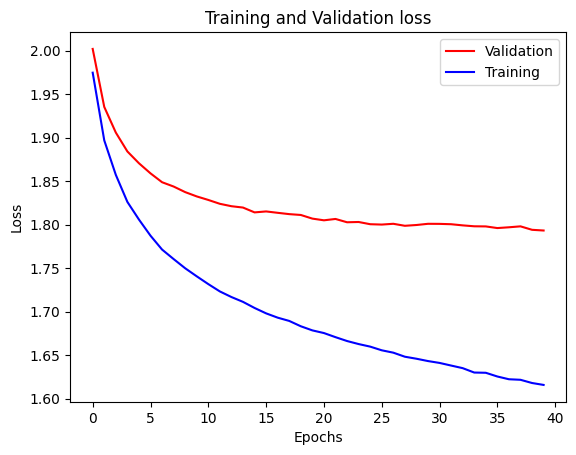

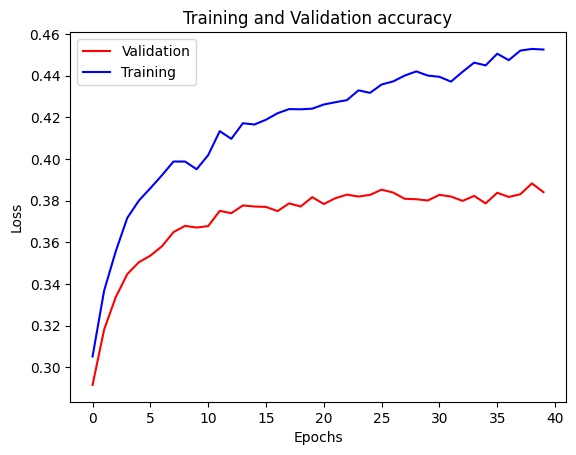

Train accuracy: 0.4526
Valid accuracy: 0.3841
Train loss: 1.6158306398381255
Valid loss: 1.7932670584505193


In [60]:
# hyperparameters
features = train.x.shape[0]
batch_size = 100
_lambda = 0
eta = 0.001
n_epochs = 40
np.random.seed(400)
random.seed(400)

nn1 = NN(w_size=(10, features), _lambda=_lambda)
train_loss, valid_loss, train_accuracy, valid_accuracy = train_nn(nn1, train, valid, n_epochs, batch_size, eta)
plot_stats(train_loss, valid_loss, "loss")
plot_stats(train_accuracy, valid_accuracy, "accuracy")

# latest train/valid accuracy and loss
print(f"Train accuracy: {train_accuracy[-1]}")
print(f"Valid accuracy: {valid_accuracy[-1]}")
print(f"Train loss: {train_loss[-1]}")
print(f"Valid loss: {valid_loss[-1]}")

lambda=0, n epochs=40, n batch=100, eta=.1

This will result in pretty unstable training, bad loss.

Valid loss: 5.291021609017992: 100%|██████████| 40/40 [00:08<00:00,  4.58it/s] 


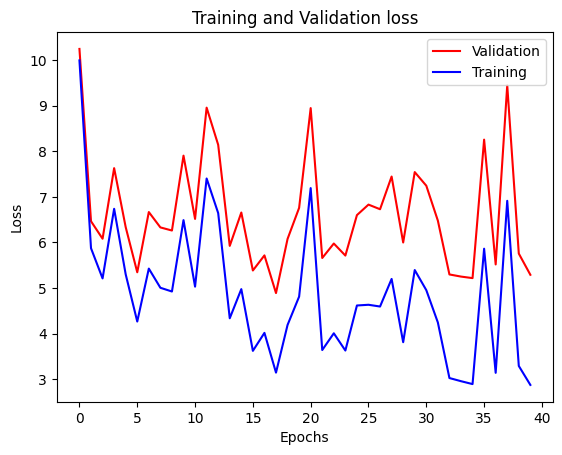

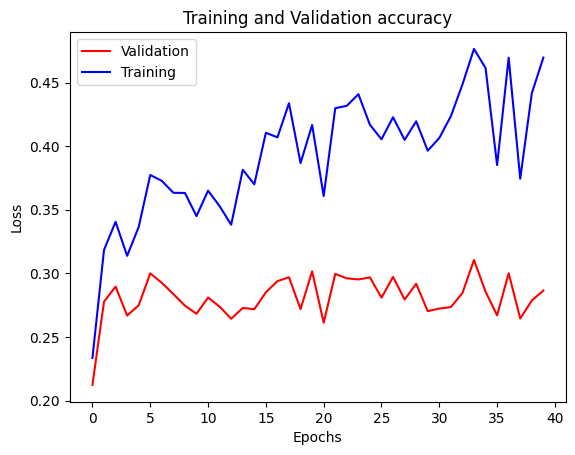

Train accuracy: 0.4696
Valid accuracy: 0.2865
Train loss: 2.877429870222895
Valid loss: 5.291021609017992


In [61]:
# hyperparameters
features = train.x.shape[0]
batch_size = 100
_lambda = 0
eta = 0.1
n_epochs = 40
np.random.seed(400)
random.seed(400)

nn2 = NN(w_size=(10, features), _lambda=_lambda)
train_loss, valid_loss, train_accuracy, valid_accuracy = train_nn(nn2, train, valid, n_epochs, batch_size, eta)
plot_stats(train_loss, valid_loss, "loss")
plot_stats(train_accuracy, valid_accuracy, "accuracy")

# latest train/valid accuracy and loss
print(f"Train accuracy: {train_accuracy[-1]}")
print(f"Valid accuracy: {valid_accuracy[-1]}")
print(f"Train loss: {train_loss[-1]}")
print(f"Valid loss: {valid_loss[-1]}")

lambda=.1, n epochs=40, n batch=100, eta=.001

Valid loss: 1.9031984393970924: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]


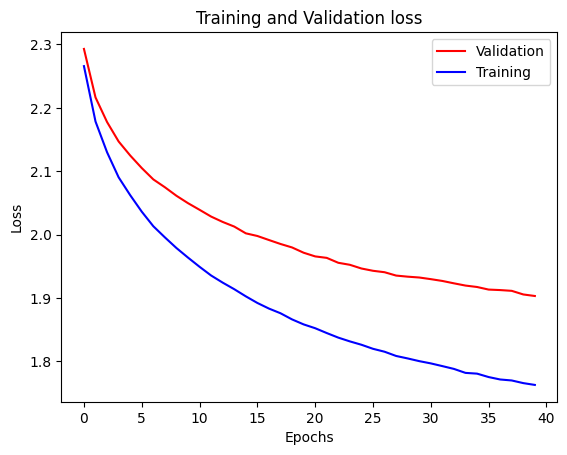

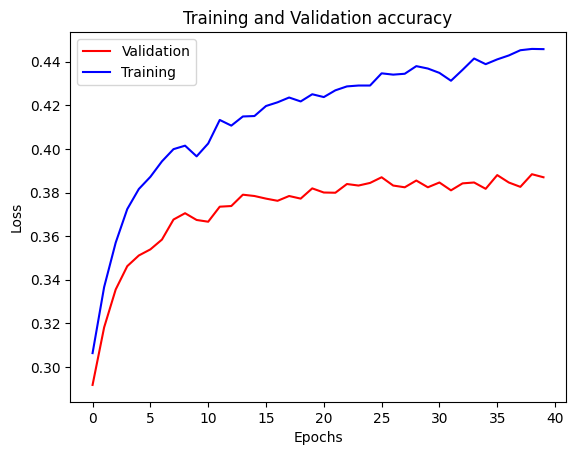

Train accuracy: 0.4458
Valid accuracy: 0.387
Train loss: 1.7629507223726275
Valid loss: 1.9031984393970924


In [62]:
# hyperparameters
features = train.x.shape[0]
batch_size = 100
_lambda = 0.1
eta = 0.001
n_epochs = 40
np.random.seed(400)
random.seed(400)

nn3 = NN(w_size=(10, features), _lambda=_lambda)
train_loss, valid_loss, train_accuracy, valid_accuracy = train_nn(nn3, train, valid, n_epochs, batch_size, eta)
plot_stats(train_loss, valid_loss, "loss")
plot_stats(train_accuracy, valid_accuracy, "accuracy")

# latest train/valid accuracy and loss
print(f"Train accuracy: {train_accuracy[-1]}")
print(f"Valid accuracy: {valid_accuracy[-1]}")
print(f"Train loss: {train_loss[-1]}")
print(f"Valid loss: {valid_loss[-1]}")

lambda=1, n epochs=40, n batch=100, eta=.001

Valid loss: 1.960365733213323: 100%|██████████| 40/40 [00:08<00:00,  4.69it/s] 


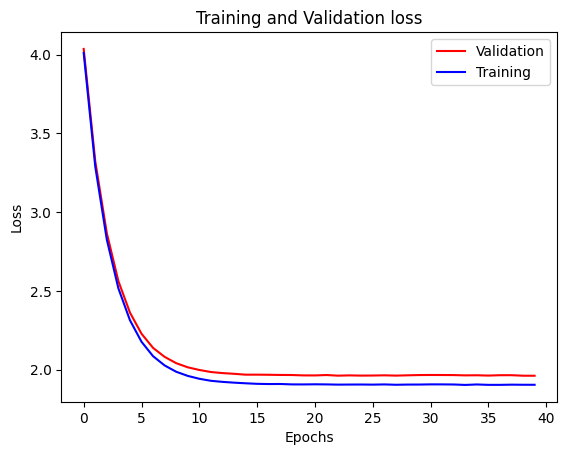

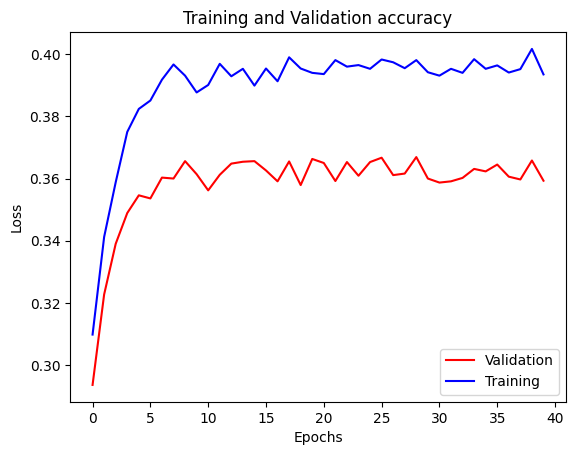

Train accuracy: 0.3935
Valid accuracy: 0.3593
Train loss: 1.9029157297928116
Valid loss: 1.960365733213323


In [63]:
# hyperparameters
features = train.x.shape[0]
batch_size = 100
_lambda = 1
eta = 0.001
n_epochs = 40
np.random.seed(400)
random.seed(400)

nn4 = NN(w_size=(10, features), _lambda=_lambda)
train_loss, valid_loss, train_accuracy, valid_accuracy = train_nn(nn4, train, valid, n_epochs, batch_size, eta)
plot_stats(train_loss, valid_loss, "loss")
plot_stats(train_accuracy, valid_accuracy, "accuracy")

# latest train/valid accuracy and loss
print(f"Train accuracy: {train_accuracy[-1]}")
print(f"Valid accuracy: {valid_accuracy[-1]}")
print(f"Train loss: {train_loss[-1]}")
print(f"Valid loss: {valid_loss[-1]}")

Let's evaluate the final test accuracy, choosing the best neural network from the 4 experiments we just ran. Whether we look at the loss or accuracy to determine the best model depends on the problem. Since we are interested in accuracy and this is just a toy model, it doesn't really matter, so I will go with accuracy. 

The best model is model 3.

In [64]:
# final test loss and accuracy
p = nn3(test.x)
print(f"Test loss: {nn3.cost(test.y, p)}")
print(f"Test accuracy: {nn3.compute_accuracy(test.y, p)}")

Test loss: 1.8786643843302926
Test accuracy: 0.3867


# Conclusion

So our final test accuracy is 38.67%, which is higher than randomly guessing which would have been 1/10. Given that we are only using a single layer and have no other techniques than a simple l2-norm regularization, this is not too bad as it indicates that the model is learning something. It's slightly lower than what my instructor got in my DL course around 38.83%, but that doesn't mean much as there are alot of variability and depends on the seed, I think I got 39.2% with seed 1. At least it seems consistent to be close to what they got.

With that said, this last experiment concludes the notebook. Hopefully it shows the process very clearly, aside from the extra stuff like center difference method, preprocessing the data and implementing the mini-batch GD, the actual forward and backward pass was very short. We simply followed the gradient formulas that we derived and that was it. Given that the formulas are logically correctly implemented, the harder part is implementing it without mistakes in practise, and knowing about some of the smaller details of numpy arrays and how to work with them can save you some time from making small hard to find mistakes. Anyways, we will be moving on to implementing a k-layer neural network in the next notebook.